In [1]:
import sys
sys.path.append("..")

from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass, twitter_preprocessor, alternate_preprocessor
from data_selector import DataSelector
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json
import random

seed = 12345678
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [3]:
preprocessor = alternate_preprocessor()

def make_loaders(args, data, batch_size, shuffle=True):
    dataset = DataClass(args, data, preprocessor=preprocessor)
    data_loader = DataLoader(dataset,
                             batch_size=int(batch_size),
                             shuffle=shuffle)

    print('The number of batches: ', len(data_loader))

    return data_loader

Reading english - 1grams ...
Reading english - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [4]:
def make_model(args, bce_weight=None):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'],
                    joint_loss=args['loss_type'],
                    alpha=args['alpha_loss'],
                    bce_weight=bce_weight,)
    
    return model


In [5]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    train_data_loader, val_data_loader = loaders

    bce_weight = args['bce_weight']
    if bce_weight == "auto": bce_weight = len(l := train_data_loader.dataset.labels) / l.sum(0) / 2
    model = make_model(args, bce_weight=bce_weight)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [6]:
hyperparams = {
    'train_path': 'data/train.csv', 
    'val_path': 'data/val.csv',
    'backbone': 'bert-base-uncased',
    'train_batch_size': 32,
    'val_batch_size': 32,
    'output_dropout': 0.1,
    'max_epoch': 10,
    'max_length': 512,
    'ffn_lr': 0.0001,
    'bert_lr': 2e-6,
    'loss_type': 'joint',
    'alpha_loss': 0.1,
    'bce_weight': 'auto',
}

In [7]:
assert False

AssertionError: 

## Train

In [8]:
def filter_neutrals(df):
    df.loc[:, "0":"10"] = (df.loc[:, "0":"10"] > 1).astype(int)
    df["filter"] = df.loc[:, "0":"10"].any(axis=1).astype(int)

    return df

In [9]:
ds = DataSelector("data.csv")
# train, val, tests = ds.select_data({"IEMOCAP": 1, "Cornell": 3, "Bolt": 3}, filter=filter_neutrals)
train, val, tests = ds.select_data(15000, filter=filter_neutrals, balance=True)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model1.5/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


/tmp/ipykernel_163046/286537917.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "0":"10"] = (df.loc[:, "0":"10"] > 1).astype(int)


In [10]:
# Random mask
mask_idx = np.random.choice(len(train), 6000, replace=False)
train.iloc[mask_idx, 0] = train.iloc[mask_idx, 0].apply(lambda x: np.concatenate((x[:-1], ["specialmasktoken"])))

In [11]:
train_loader = make_loaders(hyperparams, train, hyperparams['train_batch_size'])
val_loader = make_loaders(hyperparams, val, hyperparams['val_batch_size'])
loaders = (train_loader, val_loader)

100%|██████████| 12000/12000 [00:18<00:00, 652.09it/s]


The number of batches:  375


100%|██████████| 1500/1500 [00:02<00:00, 610.68it/s]

The number of batches:  47


In [12]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future vers

Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time
0.8335,0.6780,0.5000,0.5233,0.3880,03:59
0.7306,0.5285,0.6177,0.6324,0.5088,03:51
0.6622,0.4235,0.6900,0.7054,0.5853,03:43
0.6204,0.3762,0.7146,0.7328,0.6176,03:43
0.5962,0.3542,0.7367,0.7553,0.6479,03:43
0.5779,0.3334,0.7509,0.7684,0.6634,03:43
0.5645,0.3246,0.7639,0.7784,0.6755,03:43
0.5588,0.3252,0.7593,0.7762,0.6734,03:43
0.5528,0.3185,0.7663,0.7820,0.6808,03:43
0.5484,0.3177,0.7683,0.7840,0.6840,03:43


epoch#:  1
Validation loss decreased (inf --> 0.678002).  Saving model ...
epoch#:  2
Validation loss decreased (0.678002 --> 0.528511).  Saving model ...
epoch#:  3
Validation loss decreased (0.528511 --> 0.423521).  Saving model ...
epoch#:  4
Validation loss decreased (0.423521 --> 0.376229).  Saving model ...
epoch#:  5
Validation loss decreased (0.376229 --> 0.354226).  Saving model ...
epoch#:  6
Validation loss decreased (0.354226 --> 0.333357).  Saving model ...
epoch#:  7
Validation loss decreased (0.333357 --> 0.324618).  Saving model ...
epoch#:  8
EarlyStopping counter: 1 out of 5
epoch#:  9
Validation loss decreased (0.324618 --> 0.318484).  Saving model ...
epoch#:  10
Validation loss decreased (0.318484 --> 0.317739).  Saving model ...


In [ ]:
pd.concat((train, val, tests)).loc[:, "0":].sum(0)

0     3342
1     2727
2     3279
3     1753
4     5820
5     2006
6     4497
7     1839
8     3484
9     1696
10     943
dtype: int64

In [ ]:
m = 0
c = 0
tc = 0
for i in train_loader.dataset:
    tc += 1
    ma = i[0]['attention_mask'].sum()
    if ma > 500:
        # print(i[0]['input_ids'])
        print(ma)
        if ma > m: m = ma
        c += 1

print(m)
print(c)
print(tc)

tensor(512)
tensor(512)
1
12000


## Test

In [13]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device), model

In [14]:
hyperparams['test_batch_size'] = 32

In [15]:
test_loader = make_loaders(hyperparams, tests, hyperparams['test_batch_size'], shuffle=False)

100%|██████████| 1500/1500 [00:02<00:00, 628.32it/s]


The number of batches:  47


In [78]:
preds, model = test(hyperparams, "2023-12-28-23:53:43_checkpoint.pt", loader=test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.7829 F1-Micro: 0.7959 JS: 0.6956 Time: 00:09


In [18]:
new_tests = tests.copy()
new_tests['text'] = tests['text'].apply(lambda x: np.concatenate((x[:-1], ["specialmasktoken"])))
# new_tests['text'] = tests['text'].apply(lambda x: x[:-1])
new_test_loader = make_loaders(hyperparams, new_tests, hyperparams['test_batch_size'], shuffle=False)

100%|██████████| 1500/1500 [00:02<00:00, 675.37it/s]


The number of batches:  47


In [19]:
import transformers
tok = transformers.AutoTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [20]:
tok.decode(next(iter(new_test_loader))[0]['input_ids'][1])

"[CLS] will speaker feel anger anticipation disgust fear joy love optimism hopeless sadness surprise or trust? [SEP] speaker : < allcaps > i got a < / allcaps > 51 < allcaps > out of < / allcaps > 50 < allcaps > on my linguistics exam < / allcaps >! < repeated > [SEP] respondent : shot son! swear that's impossible hah [SEP] speaker : haha extra credit bitxh. i raped that fuxkin test [SEP] respondent : well done in proud heh, gah blogging is shitty. doing an album review [SEP] speaker : [MASK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [21]:
preds, model = test(hyperparams, "2023-12-28-23:53:43_checkpoint.pt", loader=new_test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.3834 F1-Micro: 0.4112 JS: 0.2952 Time: 00:09


In [ ]:
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

abc = np.concatenate((preds["y_true"], preds["y_pred"], preds["logits"]), axis=1)
d = pd.DataFrame(abc, columns=[name+suffix for suffix in ["_True", "_Pred", "_Logits"] for name in label_names])

In [ ]:
d.to_csv("abc.csv")

NameError: name 'd' is not defined

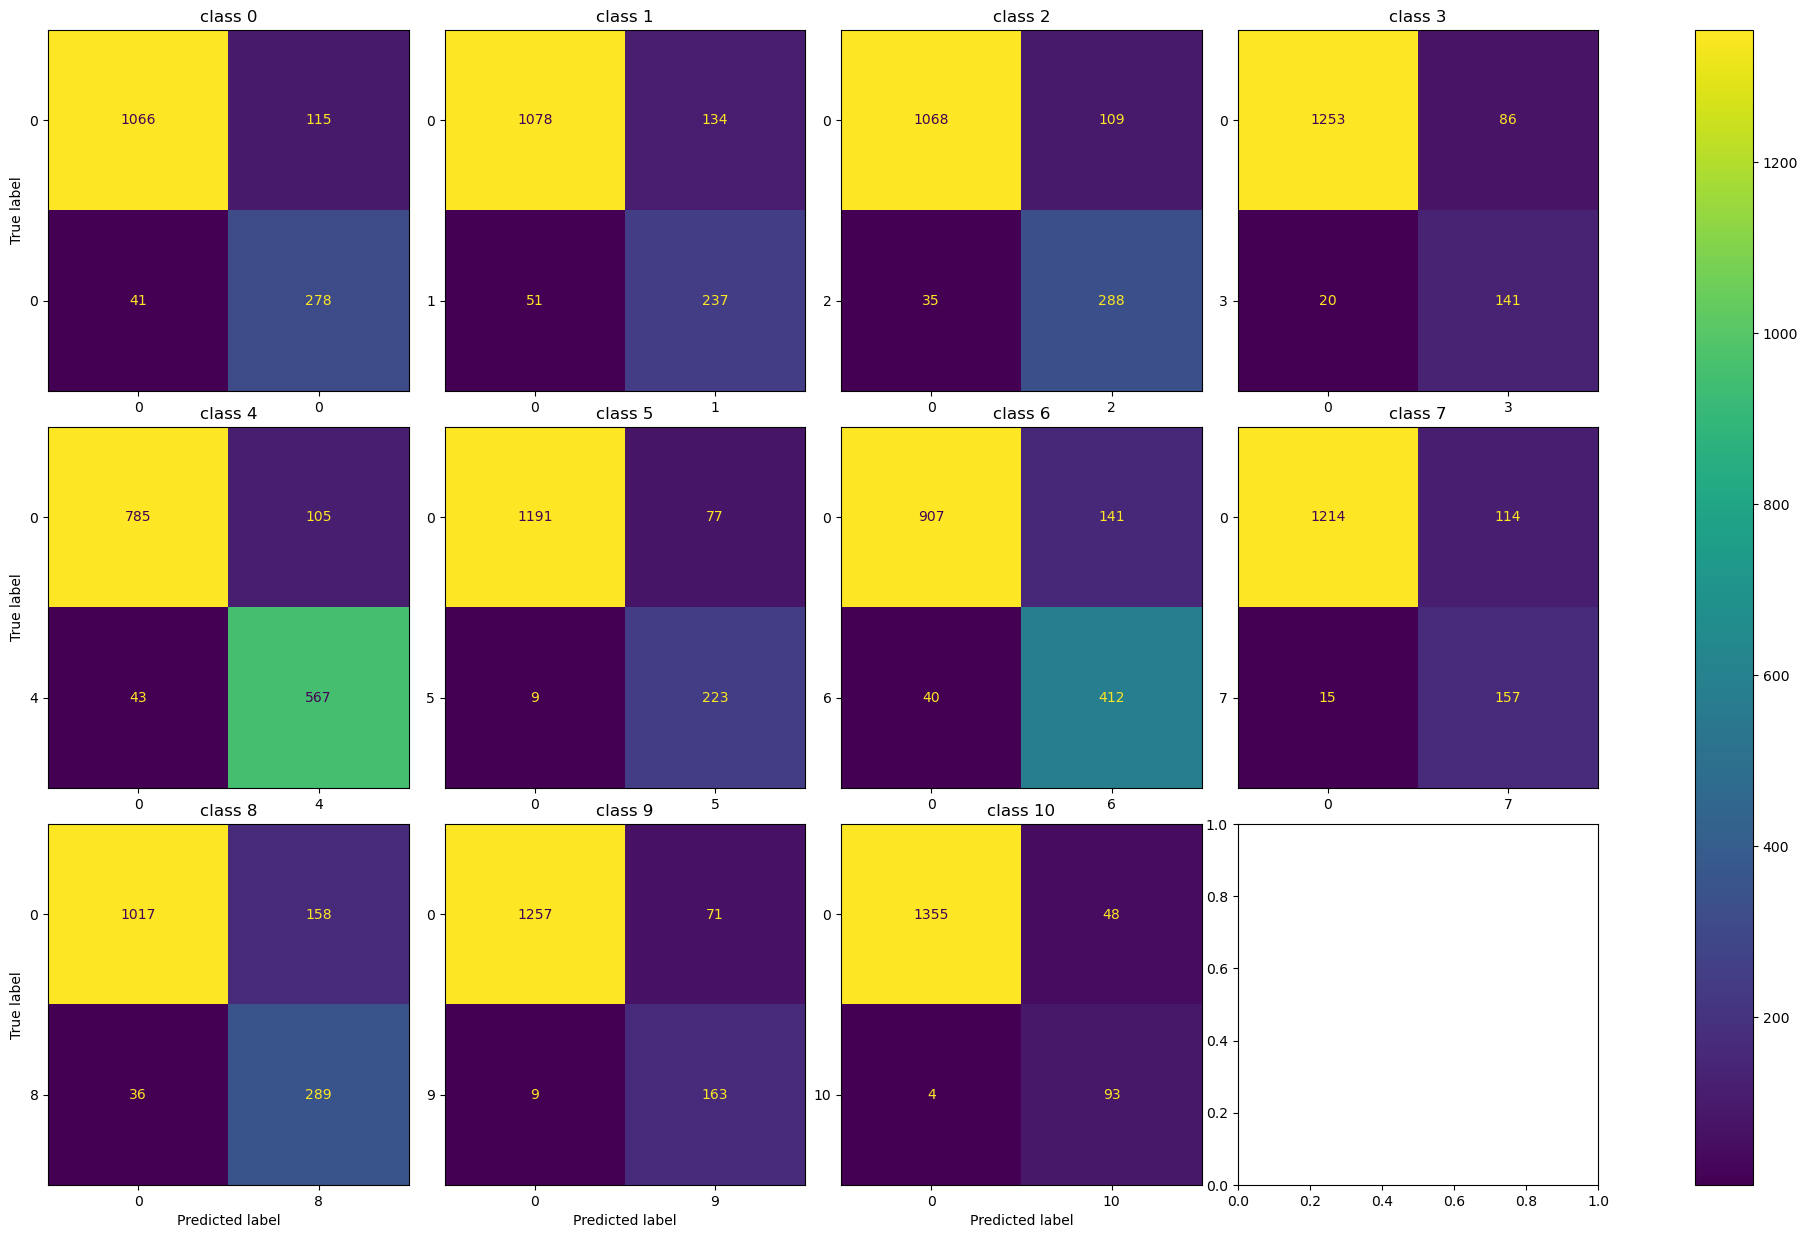

In [79]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
multilabel_confusion_matrix(preds["y_true"], preds["y_pred"])

f, axes = plt.subplots(3, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(11):
    disp = ConfusionMatrixDisplay(confusion_matrix(preds["y_true"][:, i],
                                                   preds["y_pred"][:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [25]:
loaders[0].dataset.labels.sum(0)

array([2692, 2139, 2628, 1414, 4633, 1589, 3558, 1478, 2845, 1350,  766])

In [26]:
test_loader.dataset.labels.sum(0)

array([319, 288, 323, 161, 610, 232, 452, 172, 325, 172,  97])

In [27]:
len(loaders[0].dataset)

12000

In [81]:
print("Macro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="macro"))
print("Micro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="micro"))

Macro AUC: 0.9686943991731727
Micro AUC: 0.9705799192771724


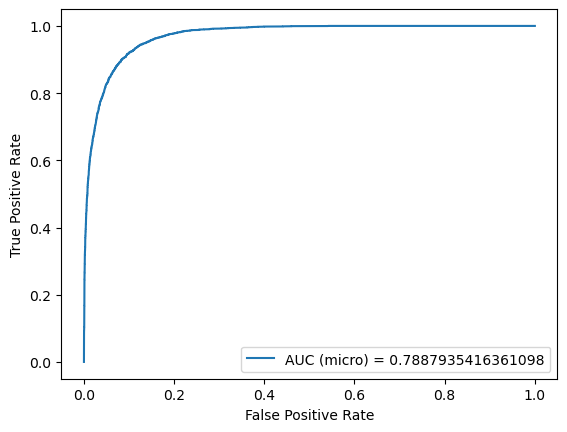

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(preds["y_true"].flatten(), preds["logits"].flatten())

plt.plot(fpr, tpr, label="AUC (micro) = 0.7887935416361098")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)

In [33]:
from sklearn.metrics import mean_squared_error

y_true = preds["y_true"]
y_prob = 1/(1+np.exp(-preds["logits"]))

stats = [mean_squared_error(y_true.flatten(), y_prob.flatten(), squared=False),
        mean_squared_error(y_true, y_prob, squared=False),
        mean_squared_error(y_true, y_prob, squared=True)]

stats

[0.41746577441148897, 0.41581559618126235, 0.17427767280498424]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["."]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    print(font_file)
    font_manager.fontManager.addfont(font_file)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/cour.ttf
/home/alexlu/Documents/Programming/alexlu07/Scires/11th/model2/model/times.ttf


In [ ]:
sns.set_theme(font="Times New Roman", style="dark")

In [ ]:
import seaborn as sns

data = sorted(zip(p[:-1], label_names[:-1]), reverse=True)

g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")
# g.tick_params(axis="x", rotation=90)

NameError: name 'p' is not defined

In [83]:
rows = tests.iterrows()
x = 0

Is that a ferret?
I think it is, Cute and smart little things
I think they could be vicious.
Like you I suppose?
Hahah they wish.


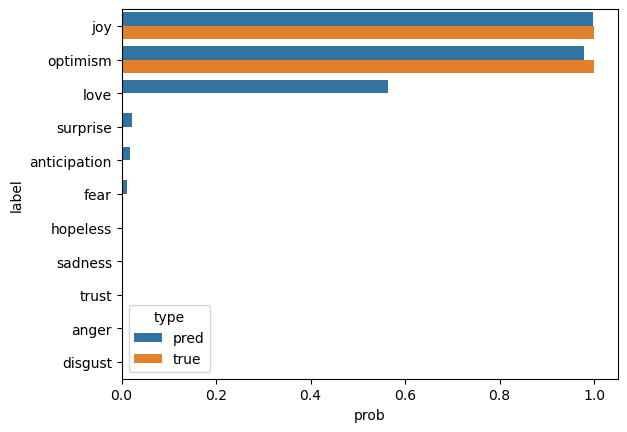

In [294]:
# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

i, row = next(rows)
text = row["text"]
probs = row.loc["0":"10"].values.astype(float)
# probs = 1/(1+np.exp(-probs))
p = 1/(1+np.exp(-preds["logits"][x]))

for t in text: print(t)

data = sorted(zip(p, probs, label_names), reverse=True)
data_df = pd.DataFrame(data, columns=["pred", "true", "label"]).melt("label", ["pred", "true"], "type", "prob")

g = sns.barplot(data_df, y="label", x="prob", hue="type", orient="h")
x += 1

In [35]:
dc = DataClass(hyperparams, [
    [
        # "",
        "i just lost my job today. it's devastating", 
        "i just found a job today, i'm so happy", 
        "this is miserable. i feel like a failure.", 
        "i can't believe my good fortune!",
        "specialmasktoken",
        # "",
        # "",
    ], [
        "I just got a promotion at work! I'm so excited and proud of myself!",
        "Wow, that's fantastic news! Congratulations! 🎉",
        "Thanks! It's been a long journey, but I finally feel recognized for my efforts.",
        "I can imagine the hard work you've put in. Your dedication has paid off. How do you feel now?",
        "well actually, i feel sad",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "life is meaningless anyways", 
        "what should i do now? what can i even do now", 
        "it's hopeless. there's no point in doing anything. life is sad",
        "yeah",
    ], [
        "i just lost everything that mattered to me. there's no point in life anymore", 
        "don't worry, i got you. look at all these good things!", 
        "oh wow, thanks! what should i do now?", 
        "just stay optimistic. don't give up",
        "yeah",
    ]], pred_mode=True, preprocessor=preprocessor)
dl = DataLoader(dc, batch_size=100, shuffle=False)

100%|██████████| 4/4 [00:00<00:00, 451.72it/s]


In [45]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[0]


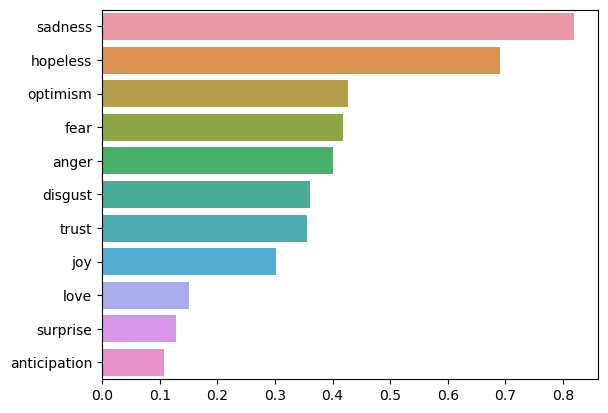

In [46]:
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]
data = sorted(zip(probs, label_names), reverse=True)
g = sns.barplot(y=[d[1] for d in data], x=[d[0] for d in data], orient="h")

In [ ]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

In [ ]:
train.loc[:, "0":"10"].sum()

0     11087
1     13725
2     10704
3      1431
4     16935
5      2995
6     15691
7      1927
8      6954
9       670
10      526
dtype: int64

In [ ]:
# _ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]